In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

import bz2

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') 
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import scipy.stats
import figure_utils as fu
from return_gene_descriptions import return_gene_descriptions

from numba import njit 

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import config
import numpy
import random as rand

from random import randint,sample,choices
from math import log

import matplotlib.cm as cm
plasma_cmap = cm.get_cmap('plasma')
import matplotlib.colors as mcolors

import sys
import os 
from scipy.spatial.distance import pdist,squareform

import matplotlib.gridspec as gridspec

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.colors import ListedColormap

hap_cmap = ListedColormap(['grey', 'red', 'black', 'black','blue'], 'indexed')

from strain_phasing_functions import *

/u/home/m/michaelw/.conda/envs/python_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  app.launch_new_instance()


In [2]:
!ls /u/project/ngarud/Garud_lab/HumanizedMouse/HumanizedMouse_Batch2/strain_phasing/input/

Adlercreutzia_equolifaciens_60310	 Dorea_longicatena_61473
Akkermansia_muciniphila_55290		 Enterococcus_avium_44557
Alistipes_finegoldii_56071		 Enterococcus_faecalis_56297
Alistipes_onderdonkii_55464		 Enterococcus_faecium_56947
Alistipes_putredinis_61533		 Escherichia_coli_58110
Alistipes_shahii_62199			 Eubacterium_cylindroides_56237
Anaerostipes_hadrus_55206		 Eubacterium_eligens_61678
Bacteroides_cellulosilyticus_58046	 Eubacterium_hallii_61477
Bacteroides_finegoldii_57739		 Eubacterium_rectale_56927
Bacteroides_fragilis_54507		 Faecalibacterium_cf_62236
Bacteroides_massiliensis_44749		 Faecalibacterium_prausnitzii_57453
Bacteroides_ovatus_58035		 Faecalibacterium_prausnitzii_61481
Bacteroides_pectinophilus_61619		 Faecalibacterium_prausnitzii_62201
Bacteroides_thetaiotaomicron_56941	 Guyana_massiliensis_60772
Bacteroides_uniformis_57318		 Intestinimonas_butyriciproducens_60001
Bacteroides_vulgatus_57955		 Lachnospiraceae_bacterium_51870
Barnesiella_intestinihominis_62208	 Lachnos

In [3]:
species = "Bacteroides_uniformis_57318"


## Directories

In [4]:
strainfinder_dir = "%sinput" % (config.strain_phasing_directory)

#Raw cluster
raw_cluster_path = "%s%s" % (config.strain_phasing_directory, "strain_clusters/")
species_raw_cluster_dir = "%s%s/" % (raw_cluster_path, species)
if not os.path.exists(species_raw_cluster_dir):
    os.makedirs(species_raw_cluster_dir)
    print("Cluster directory created successfully!")
else:
    print("Cluster directory already exists.")
species_raw_cluster_path = "%s%s%s" % (species_raw_cluster_dir, species, "_RawCluster.pckl")

#Centroid and polarized cluster paths
species_centroid_cluster_path = "%s%s%s" % (species_raw_cluster_dir, species, "_ClusterCentroid.pckl")
species_polarized_cluster_path = "%s%s%s" % (species_raw_cluster_dir, species, "_PolarizedCluster.pckl")

#FINAL Fs path
final_Fs_path = "%s%s%s" % (species_raw_cluster_dir, species, "_final_Fs.pckl")

#Evolutionary SNPs
evo_snvs_directory = "%sstrain_phasing/snp_changes/%s/" % (config.project_directory, species)
inoculum_to_mouse_changes_path = "%s%s%s" % (evo_snvs_directory, species,"_inoculum_mouse_changes.pckl")
all_snp_changes_path = "%s%s%s" % (evo_snvs_directory, species,"_all_snp_changes.pckl")

#MIDAS data
annotated_snps_path = "%ssnps/%s/annotated_snps.txt.bz2" % (config.data_directory, species)

# #Figure directory
# figure_directory = "%s%s%s" % (config.figure_directory, "strain_phasing/", species)
# if not os.path.exists(figure_directory):
#     os.makedirs(figure_directory)
#     print("Figure directory created successfully!")
# else:
#     print("Figure directory already exists.")


Cluster directory already exists.


## Analysis

In [5]:
## Meta-parameters: experiment with these—no hard and fast rules!

## minimum number of SNVs which need to be clustered together in order to qualify as a "strain"
## if we didn't cap max_num_snvs, then min_cluster_size would be O(10^4), based on the typical evolutionary
## distance between strains
min_cluster_size = 1000
# min_cluster_size = 50

## minimum fraction of sites which pass our coverage threshold which must be in a cluster in order for it to qualify 
## as a strain
## basically, the idea is that as the initial number of sites we pass in gets bigger, we want to incrwease the min_cluster_size
## here, we say that 10% of all variable sites must be in a cluster in order for it to be considered a "strain"
## this will largely be redundant w/ min_cluster_size, but adds some more functionality to play with
min_cluster_fraction = 1/10
#min_cluster_fraction = 0

## For computational efficiency, we can downsample the SNVs we actually perform strain phasing on
## should still give us the same strain trajectory 
## clustering 20k SNVs takes ~90 seconds. 
max_num_snvs = 20000

## distance threshold to be considered linked—lower means trajectories have to be more 
## similar, higher means less similar, to be in a cluster
    
max_d = 3.5
# max_d = 6 #USE THIS FOR B. WEXLERAE
#max_d = 4 #USE THIS FOR B. UNIFORMIS, A. hadrus
#max_d = 5 #Coprococcus_sp_62244


## minimum coverage to consider allele frequency at a site for purposes of clustering
min_coverage = 10 #MW: 20 until 6/30/2024
# min_coverage = 5

## minimum average sample coverage at polymorphic sites (e.g. sites in the A/D matrices)
min_sample_coverage = 5
# min_sample_coverage = 0


## polymorphic & covered fraction: what percentage of samples does a site need 
## with coverage > min_coverage and polymorphic to be included in downstream analyses? 
## NOTE: we may want to disaggregate coverage and polymorphic-ness so as to not lose evolutionary snvs
## but for strain clustering purposes, I think we should focus on SNVs that are actually polymorphic
## in a good number of samples
poly_cov_frac = 1/5 #

## Number of clusters to calculate
n_clusters = 100
#n_clusters = 500

#Minimum number of snvs per sample
min_num_snvs_per_sample = 100

#Another idea: cluster the centroids. If centroids are below a certain distance from each other, just merge. 


In [6]:
Fs,Ass,Dss = return_FAD(species, min_coverage=min_coverage, 
                        min_sample_coverage=min_sample_coverage, 
                        poly_cov_frac = poly_cov_frac, 
                        calculate_poly_cov_frac=True, 
                        read_support = True) 


Using a read support of 4 for each polymorphism.


In [7]:
#filter out samples without an adequate number of SNVs when all is said and done
sample_with_adequate_snv_count = ~((~np.isnan(Fs)).sum() < min_num_snvs_per_sample)

Fs = Fs.loc[:,sample_with_adequate_snv_count]
Ass = Ass.loc[:,sample_with_adequate_snv_count]
Dss = Dss.loc[:,sample_with_adequate_snv_count]

In [8]:
#Copying the Inoculum

Fs_inoculum = Fs.loc[:,(Fs.columns.get_level_values('sample') == 'TL1gDNAshort')]

Ass_inoculum = Ass.loc[:,(Ass.columns.get_level_values('sample') == 'TL1gDNAshort')]

Dss_inoculum = Dss.loc[:,(Dss.columns.get_level_values('sample') == 'TL1gDNAshort')]



In [ ]:
%%time


fss = Ass.values/(Dss.values + (Dss.values == 0)) #This is so it doesn't produce a na (division by 0)

cluster_As = Ass.values
cluster_Ds = Dss.values
cluster_fs = cluster_As/(cluster_Ds + (cluster_Ds == 0))

## for compatibility in case of threshold number of SNVs
num = min(max_num_snvs,Fs.shape[0])

i_list = Dss.T.mean().sort_values(ascending=False).index[:num]

sys.stderr.write("Processing %s SNVs" % num)

## simply shuffles indices if no threshold is specified
#i_list = sample(range(Fs.shape[0]),num)
i_list_idx = Fs.loc[i_list].index

Ass_sub = Ass.loc[i_list_idx]
Dss_sub = Dss.loc[i_list_idx]
Fs_sub = Fs.loc[i_list_idx]

fss_sub = Ass_sub.values/(Dss_sub.values + (Dss_sub.values == 0))

cluster_As_sub = Ass_sub.values
cluster_Ds_sub = Dss_sub.values
cluster_fs_sub = cluster_As_sub/(cluster_Ds_sub + (cluster_Ds_sub == 0))

D_mat = np.zeros([num,num])
D_mat_1 = D_mat_fun1(num,fss_sub,cluster_Ds_sub,D_mat)
D_mat = np.zeros([num,num]) 
D_mat_2 = D_mat_fun2(num,fss_sub,cluster_Ds_sub,D_mat)

D_mat = np.fmin(D_mat_1,D_mat_2) #I believe this is filling in the minimum of the two polarizations
D_mat = symmetrize(D_mat)

D_mat_1 = pd.DataFrame(D_mat_1,index=Fs_sub.index,columns=Fs_sub.index)
D_mat_2 = pd.DataFrame(D_mat_2,index=Fs_sub.index,columns=Fs_sub.index)

D_mat_close = pd.DataFrame(D_mat < max_d) 

D_mat_close.index = Fs_sub.index
D_mat_close.columns = Fs_sub.index


In [ ]:
## extracts up to 100 clusters
## in practice all SNVs should fall into one of a fairly small number of clusters
## really should re-write this with a while loop but this works for now
## the idea is that we exhaust all clusters—there should only be a small number of them ultimately

###Idea with while loop:
##### While there are still variants out there, have it try to be clusterings

all_clus_pol = []
all_clus_idx = []
all_clus_A = []
all_clus_D = []

all_clus_F = []

if species == "Bacteroides_uniformis_57318": #MW 7/17/2024
    
    clus_1,clus_idxs_1 = return_clus(D_mat_close,Fs_sub)
    clus_pol_1 = polarize_clus(clus_1,clus_idxs_1,D_mat_1,D_mat_2)
    clus_pol_1.index = clus_idxs_1
    D_mat_close = drop_clus_idxs(D_mat_close,clus_idxs_1)
    
    clus_2,clus_idxs_2 = return_clus(D_mat_close,Fs_sub)
    clus_pol_2 = polarize_clus(clus_2,clus_idxs_2,D_mat_1,D_mat_2)
    clus_pol_2.index = clus_idxs_2
    D_mat_close = drop_clus_idxs(D_mat_close,clus_idxs_2)
    
    clus = pd.concat([clus_1, clus_2], axis = 0)
    clus_idxs = clus_idxs_1.append(clus_idxs_2)
    clus_pol = pd.concat([clus_pol_1, clus_pol_2], axis = 0)
    
    all_clus_D.append(Dss.loc[clus.index].mean().values)
    all_clus_pol.append(clus_pol)
    all_clus_A.append(clus_pol.mean()*all_clus_D[-1])
    all_clus_F.append(clus_pol.mean())
    
    print(clus_pol.shape[0])

    
else:

    for i in range(n_clusters):

        try:

            clus,clus_idxs = return_clus(D_mat_close,Fs_sub)
    #         clus,clus_idxs = return_clus(D_mat_close,Fs_sub, co_cluster_pct=0.5) #Finding points that cluster with 25% other points. That's a cluster.
                                                             #We would modify this function to get smaller clusters...
            clus_pol = polarize_clus(clus,clus_idxs,D_mat_1,D_mat_2)
            clus_pol.index = clus_idxs
            D_mat_close = drop_clus_idxs(D_mat_close,clus_idxs)

            if clus_pol.shape[0] > min_cluster_size and clus_pol.shape[0] > Fs.shape[0]*min_cluster_fraction:

                all_clus_D.append(Dss.loc[clus.index].mean().values)
                all_clus_pol.append(clus_pol)
                all_clus_A.append(clus_pol.mean()*all_clus_D[-1])
                all_clus_F.append(clus_pol.mean())

                print(clus_pol.shape[0])

        except:
            pass


In [ ]:
## now, choosing a representative SNV from each cluster, and finding all other sites (not just limited to the 20k)
## which are consistent w/ being linked to it

final_clusters = []

all_aligned_sites = []

for i in range(len(all_clus_D)):
    
    sys.stderr.write(f'\n\nCluster {i+1}\n')
    ancD = all_clus_D[i]
    ancF = all_clus_F[i]

    dss = Dss.values
    fss = Fs.values
    
    disAnc_forward = []
    disAnc_backward = []

    for j in range(Dss.shape[0]):
        disAnc_forward.append(calc_dis(ancD,dss[j],ancF,fss[j]))
        disAnc_backward.append(calc_dis(ancD,dss[j],ancF,1-fss[j]))
        if j % 1000 == 0:
            sys.stderr.write(f"\n\t{np.around(100*j/Dss.shape[0],3)}% finished")
    
    disAnc = [min(els) for els in zip(disAnc_forward, disAnc_backward)]
    disAnc = np.array(disAnc)
    aligned_sites = Fs.loc[disAnc < max_d].index
    f_dist =  pd.DataFrame(np.array([disAnc_forward,disAnc_backward]).T,index=Fs.index)
    pols = f_dist.T.idxmin() > 0
    
    aligned_sites = [a for a in aligned_sites if a not in all_aligned_sites]
    
    pols = pols.loc[aligned_sites]
    re_polarize = pols.loc[pols].index
    
    all_aligned_sites.extend(aligned_sites)
    
    Fs_cluster = Fs.loc[aligned_sites]
    
    Fs_cluster.loc[re_polarize] = 1 - Fs_cluster.loc[re_polarize]
        
    final_clusters.append(Fs_cluster)
    

In [ ]:
# #TRUE for: B. uniformis
# if species == "Bacteroides_uniformis_57318":
#     clusters_to_merge=[0,1]

#     i = 0
#     while i < len(clusters_to_merge)-1:
#         final_clusters[clusters_to_merge[0]] = final_clusters[i].append(final_clusters[i+1])
#         i += 1

#     clusters_to_remove = clusters_to_merge[1:]

#     final_clusters = [final_clusters[cluster] for cluster in np.arange(len(final_clusters)) if cluster not in clusters_to_remove]

In [ ]:
#SAVING RAW FILE

pickle_object = open(species_raw_cluster_path, "wb")
pickle.dump(final_clusters, pickle_object)
pickle_object.close()

In [9]:
#LOADING THE RAW FILE

final_clusters = pd.read_pickle(species_raw_cluster_path)

## Creating polarized clusters

Once clusters have been identified and internally polarized, they need to be polarized relative to one another. In the best case, the sum of strain frequencies will be 1. 

In [10]:
no_cluster = False
multiple_inoculum_strains = False
if (len(final_clusters) == 0):
    sys.stderr.write("No clusters detected.\n")
    no_cluster = True
    
    Fs_nc,Ass_nc,Dss_nc = return_FAD(species, 
                            min_coverage=min_coverage,
                            min_sample_coverage=min_sample_coverage,
                            poly_cov_frac = 0, 
                            calculate_poly_cov_frac=False, 
                            read_support = False)
    
    if ("Inoculum" not in Fs_nc):
        sys.stderr.write("Inoculum not in data.\n")
        if Fs_nc.mean().mean() < 0.5:
            df_final_f = 1 - Fs_nc.mean().T
            df_final_f.loc[:,:] = 1
            final_f = []
            final_f.append(df_final_f)
            final_clusters = []
            final_clusters.append(1 - Fs_nc)
        else:
            df_final_f = Fs_nc.mean().T
            df_final_f.loc[:,:] = 1
            final_f = []
            final_f.append(df_final_f)
            final_clusters = []
            final_clusters.append(Fs_nc)
        
    elif ((((Fs_nc > 0.0) | (Fs_nc < 1.0)) & (Ass_nc > 4)).sum()["Inoculum"].values[0] > min_cluster_size):
        #If the number of supported polymoprhic SNVs in the inoculum > 1000, infer two strains in the inoculum
        sys.stderr.write("Multiple strains detected in inoculum.\n")
        multiple_inoculum_strains = True
        Fs_nc = Fs_nc.loc[:,((Dss_nc > min_coverage).sum() > min_cluster_size)]
        Ass_nc = Ass_nc.loc[:,((Dss_nc > min_coverage).sum() > min_cluster_size)]
        Dss_nc = Dss_nc.loc[:,((Dss_nc > min_coverage).sum() > min_cluster_size)] #Number of good coverage sites exceeds 1000
        
        if Fs_nc.mean().mean() < 0.5:
            #if alleles are polarized such that the alt is < 0.5, flip the polarization
            #extract mean using only polymorphic sites in the inoculum
            Fs_nc = Fs_nc.loc[Fs_nc['Inoculum'][(Fs_nc['Inoculum'] > 0) & (Dss_nc['Inoculum'] > 4)].dropna().index]
            Ass_nc = Ass_nc.loc[Fs_nc['Inoculum'][(Fs_nc['Inoculum'] > 0) & (Dss_nc['Inoculum'] > 4)].dropna().index]
            Dss_nc = Dss_nc.loc[Fs_nc['Inoculum'][(Fs_nc['Inoculum'] > 0) & (Dss_nc['Inoculum'] > 4)].dropna().index]
            df_final_f = 1 - Fs_nc.mean().T
            columns_to_update = pd.DataFrame(df_final_f).T.columns.difference([('Inoculum', 'Inoculum', 'Human diet', 'Inoculum', 'TL1gDNAshort')])
            df_final_f = pd.DataFrame(df_final_f).T
            df_final_f.loc[:,columns_to_update] = 1
            df_final_f = df_final_f.mean()
            final_f = []
            final_f.append(df_final_f)
            final_f.append(1 - df_final_f)
            final_clusters = []
            final_clusters.append(1 - Fs_nc)
            final_clusters.append(Fs_nc)
            
        else:
            Fs_nc = Fs_nc.loc[Fs_nc['Inoculum'][(Fs_nc['Inoculum'] < 1) & (Dss_nc['Inoculum'] > 4)].dropna().index]
            Ass_nc = Ass_nc.loc[Fs_nc['Inoculum'][(Fs_nc['Inoculum'] < 1) & (Dss_nc['Inoculum'] > 4)].dropna().index]
            Dss_nc = Dss_nc.loc[Fs_nc['Inoculum'][(Fs_nc['Inoculum'] < 1) & (Dss_nc['Inoculum'] > 4)].dropna().index]
            df_final_f = Fs_nc.mean().T
            columns_to_update = pd.DataFrame(df_final_f).T.columns.difference([('Inoculum', 'Inoculum', 'Human diet', 'Inoculum', 'TL1gDNAshort')])
            df_final_f = pd.DataFrame(df_final_f).T
            df_final_f.loc[:,columns_to_update] = 1
            df_final_f = df_final_f.mean()
            final_f = []
            final_f.append(df_final_f)
            final_f.append(1-df_final_f)
            final_clusters = []
            final_clusters.append(Fs_nc)
            final_clusters.append(1 - Fs_nc)
            
    else:
        sys.stderr.write("A single strain detected in inoculum.\n")
        Fs_nc = Fs_nc.loc[:,((Dss_nc > min_coverage).sum() > min_cluster_size)]
        Ass_nc = Ass_nc.loc[:,((Dss_nc > min_coverage).sum() > min_cluster_size)]
        Dss_nc = Dss_nc.loc[:,((Dss_nc > min_coverage).sum() > min_cluster_size)] #Number of good coverage sites exceeds 1000
        df_final_f = Fs_nc.mean().T
        df_final_f.loc[:,:] = 1
        final_f = []
        final_f.append(df_final_f)
        if (Fs_nc.mean().mean() < 0.5): 
            #if alleles are polarized such that the alt is < 0.5, flip the polarization
            final_clusters = []
            final_clusters.append(1 - Fs_nc)
        else:
            final_clusters = []
            final_clusters.append(Fs_nc)
else:
    sys.stderr.write("Multiple strains detected.\n")
    ## If only a single cluster is detected, add a second "cluster" which is simply 1 minus the allele frequencies
    ## in the first cluster
    ## aids in visualization for people not familiar with this kind of clustering
    if len(final_clusters) == 1:
        final_clusters.append(1-final_clusters[0])
    
    ## add cluster centroids
    final_f = []
    for cluster in final_clusters:
        final_f.append(cluster.mean())
    df_final_f = pd.DataFrame(final_f)

    ## now, polarize clusters so that the sum of squareds of the centroids to 1 is minimized
    ## the idea here is that accurate strain frequencies should sum to 1
    polarize = True
    
    pol_d2 = {}

    for i in range(df_final_f.shape[0]):
        df_final_f_temp = df_final_f.copy() #Makes a copy of the centroids
        df_final_f_temp.iloc[i] = 1 - df_final_f_temp.iloc[i] #gets the polarized version of ONE of the centroids.
        pol_d2[i] =  ((1 - df_final_f_temp.sum())**2).sum()   #Get the across centroids for all samples (should be close to 1), 
                                                                  #subtract this from 1, and square. Sum all those values
                                                                  #Ideally, this value is really close to 0. 
                                                                  #Add this value to the dictionary.

        pol_d2 = pd.Series(pol_d2)                                #Make the dictionary a series 

        if pol_d2.min() < ((1 - df_final_f.sum())**2).sum(): #If any of the above repolarizations actually made the overall sum of centroids closer to 1, repolarize.
            clus_to_re_pol = pol_d2.idxmin()
            final_f[clus_to_re_pol] = 1 - final_f[clus_to_re_pol]
            final_clusters[clus_to_re_pol] = 1 - final_clusters[clus_to_re_pol]
            df_final_f = pd.DataFrame(final_f)  
            Fs_inoculum.loc[final_clusters[clus_to_re_pol].index] = 1 -  Fs_inoculum.loc[final_clusters[clus_to_re_pol].index]#polarize inoculum accordingly

    
    

Multiple strains detected.


In [11]:
demonstration = False
if demonstration:
    final_clusters.pop(0)
    final_f.pop(0)

### Filtering out samples in which each cluster does not have adequate snvs

In [12]:
good_indices = []

for i,cluster in enumerate(final_clusters):
    if i == 0:
        good_samples = (len(final_clusters[i]) - np.isnan(final_clusters[i]).sum(axis = 0) > min_num_snvs_per_sample).values
    else:
        new_good_samples = (len(final_clusters[i]) - np.isnan(final_clusters[i]).sum(axis = 0) > min_num_snvs_per_sample).values
        good_samples = good_samples & new_good_samples

for i,cluster in enumerate(final_clusters): 
    final_clusters[i] = final_clusters[i].T.loc[good_samples].T
    final_f[i] = final_f[i].T.loc[good_samples]
if no_cluster:
    Fs = Fs_nc.T.loc[good_samples].T
    Ass = Ass_nc.T.loc[good_samples].T
    Dss = Dss_nc.T.loc[good_samples].T
else:
    Fs = Fs.T.loc[good_samples].T
    Ass = Ass.T.loc[good_samples].T
    Dss = Dss.T.loc[good_samples].T
    

In [13]:
#Filter all all na columns if there are any - THis is redundant
if len(final_clusters) > 0:
    for i,cluster in enumerate(final_clusters):
        if i == 0:
            mask = ~np.isnan(cluster).all(axis = 0)
        final_clusters[i] = cluster.loc[:,mask]
        final_f[i] = final_f[i][mask]
    Fs = Fs.loc[:,mask]

In [ ]:


#SAVING RAW FILE

pickle_object = open(species_centroid_cluster_path, "wb")
pickle.dump(final_f, pickle_object)
pickle_object.close()

pickle_object = open(species_polarized_cluster_path, "wb")
pickle.dump(final_clusters, pickle_object)
pickle_object.close()

pickle_object = open(final_Fs_path, "wb")
pickle.dump(Fs, pickle_object)
pickle_object.close()

Text(0, 0.5, 'Sum of strain frequencies')

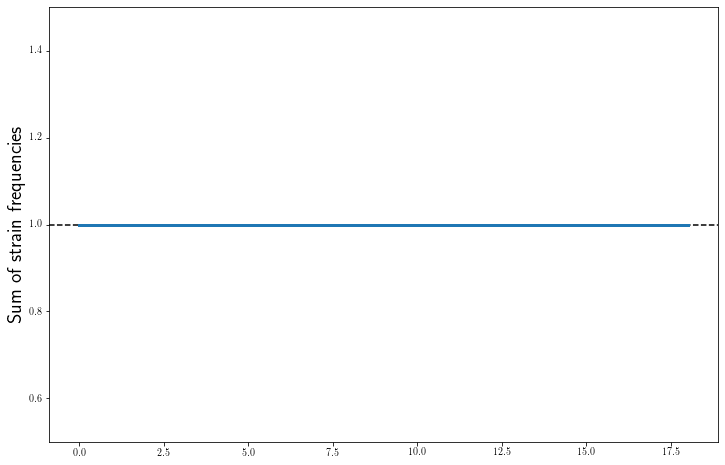

In [14]:
## plot the chosen polarization of strains
## sum of strain frequencies should be ~1 at all timepoints

fig,ax = plt.subplots(figsize=(12,8))
ax.plot(pd.DataFrame(final_f).sum().values,zorder=10,lw=3)
ax.set_ylim([.5,1.5])
ax.axhline(1,color="k",ls="--")
ax.set_ylabel("Sum of strain frequencies",size=20)



## Saving versions for R plotting

In [ ]:
all_strains = True
bootstrap_ci = True
boostrap_k = 100
bootstrap_N = 1000
if all_strains:  
    for i in np.arange(len(final_f)): 
        if i == 0:
            final_f_all_strains = pd.DataFrame(final_f[i]).reset_index().rename(columns = {0: "freq"})
            final_f_all_strains['species'] = [species]*len(final_f_all_strains)
            final_f_all_strains['strain'] = [i + 1]*len(final_f_all_strains)
            final_f_all_strains = final_f_all_strains[['species','strain','mouse_number', 'region', 'diet', 'cage', 'sample', 'freq']]
            iqr_75 = pd.DataFrame(final_clusters[i].quantile(0.75)).reset_index()
            iqr_25 = pd.DataFrame(final_clusters[i].quantile(0.25)).reset_index()
            final_f_all_strains = final_f_all_strains.merge(iqr_25).merge(iqr_75)
            if bootstrap_ci:
                upper_ci_vec = []
                lower_ci_vec = []
                
                for sample_i in range(final_clusters[i].shape[1]):
                    
                    sample_name = final_clusters[i].iloc[:,sample_i].name[4]
                    if  (no_cluster) & (multiple_inoculum_strains) & (sample_name != "TL1gDNAshort"):
                        upper_ci_vec.append(np.nan)
                        lower_ci_vec.append(np.nan)
                    
                    elif (no_cluster) & (not multiple_inoculum_strains):
                        upper_ci_vec.append(np.nan)
                        lower_ci_vec.append(np.nan)
                        
                    else:
                        snv_freqs = final_clusters[i].iloc[:,sample_i].dropna().to_list()
                        mean_freq_vec = []
                        for n in range(bootstrap_N):
                            sampled_snv_freqs = choices(snv_freqs, k = boostrap_k)
                            mean_freq = np.mean(sampled_snv_freqs)
                            mean_freq_vec.append(mean_freq)
                        upper_ci = np.quantile(mean_freq_vec, 0.975)
                        lower_ci = np.quantile(mean_freq_vec, 0.025)
                        upper_ci_vec.append(upper_ci)
                        lower_ci_vec.append(lower_ci)
                    
                

        else:

            final_f_all_strains_temp = pd.DataFrame(final_f[i]).reset_index().rename(columns = {0: "freq"})
            final_f_all_strains_temp['species'] = [species]*len(final_f_all_strains_temp)
            final_f_all_strains_temp['strain'] = [i + 1]*len(final_f_all_strains_temp)
            final_f_all_strains_temp = final_f_all_strains_temp[['species','strain','mouse_number', 'region', 'diet', 'cage', 'sample', 'freq']]
            iqr_75 = pd.DataFrame(final_clusters[i].quantile(0.75)).reset_index()
            iqr_25 = pd.DataFrame(final_clusters[i].quantile(0.25)).reset_index()
            final_f_all_strains_temp = final_f_all_strains_temp.merge(iqr_25).merge(iqr_75)
            final_f_all_strains = final_f_all_strains.append(final_f_all_strains_temp, ignore_index = True)
            if bootstrap_ci:
                
                for sample_i in range(final_clusters[i].shape[1]): #if we did not infer multiple strains, but there may have been multiple strains in the inoculum, just calculate CI for inoculum
                    sample_name = final_clusters[i].iloc[:,sample_i].name[4]
                    if  (no_cluster) & (multiple_inoculum_strains) & (sample_name != "TL1gDNAshort"):
                        upper_ci_vec.append(np.nan)
                        lower_ci_vec.append(np.nan)
                   
                    elif (no_cluster) & (not multiple_inoculum_strains):
                        upper_ci_vec.append(np.nan)
                        lower_ci_vec.append(np.nan)
                        
                    else:
                        snv_freqs = final_clusters[i].iloc[:,sample_i].dropna().to_list()
                        mean_freq_vec = []
                        for n in range(bootstrap_N):
                            sampled_snv_freqs = choices(snv_freqs, k = boostrap_k)
                            mean_freq = np.mean(sampled_snv_freqs)
                            mean_freq_vec.append(mean_freq)
                        upper_ci = np.quantile(mean_freq_vec, 0.975)
                        lower_ci = np.quantile(mean_freq_vec, 0.025)
                        upper_ci_vec.append(upper_ci)
                        lower_ci_vec.append(lower_ci)
            
            
        final_f_all_strains['upper_ci'] = upper_ci_vec
        final_f_all_strains['lower_ci'] = lower_ci_vec
    #Renaming
    final_f_all_strains = final_f_all_strains.rename(columns = {0.25: "quantile_25", 0.75: "quantile_75"})
    
    #Saving 
    
    output_file = "%sstrain_phasing/strain_clusters/%s/%s_strain_frequency.csv" % (config.project_directory, species, species)
    final_f_all_strains.to_csv(output_file, sep = "\t", index = False)
    

## Plotting strain frequencies

Strain frequencies can be plotted using a main key (e.g. mouse_number) and a secondary key (e.g. region), yielding a two-level identification of each sample

In [15]:
## More ordering utilities
mnum = list(set(Fs.T.index.get_level_values("mouse_number")))
msite = list(set(Fs.T.index.get_level_values("region")))
mdiet = list(set(Fs.T.index.get_level_values("diet")))
mcage = list(set(Fs.T.index.get_level_values("cage")))

mnum_sample_dic = {m:np.argwhere(reorder_sort(Fs.T,"mouse_number").index.get_level_values("mouse_number") == m).ravel() for m in list(set(mnum))}

msite_sample_dic = {m:np.argwhere(reorder_sort(Fs.T,"region").index.get_level_values("region") == m).ravel() for m in list(set(msite))}

mdiet_sample_dic = {m:np.argwhere(reorder_sort(Fs.T,"diet").index.get_level_values("diet") == m).ravel() for m in list(set(mdiet))}

mcage_sample_dic = {m:np.argwhere(reorder_sort(Fs.T,"cage").index.get_level_values("cage") == m).ravel() for m in list(set(mcage))}

all_sample_dics = {"diet":mdiet_sample_dic,"region":msite_sample_dic,"mouse_number":mnum_sample_dic,"cage":mcage_sample_dic}


In [16]:
final_clusters[1]

mouse_number                                                        1  \
region                                                          Cecum   
diet                                                     Control diet   
cage                                                           Cage 1   
sample                            M1CeC_CKDN220050952-1A_H7MMHDSX5_L3   
contig      site_pos all_site_pos                                       
NZ_DS362220 11382    11382                                        NaN   
            11448    11448                                   1.000000   
            11501    11501                                   0.857143   
            11732    11732                                   0.933333   
            11813    11813                                   0.761905   
...                                                               ...   
NZ_DS362249 512321   4257355                                 0.538462   
            512408   4257442                                      NaN   
            512519   4257553                                      NaN   
            512531   4257565                                      NaN   
            512558   4257592                                 0.750000   

mouse_number                                                           \
region                                                          Colon   
diet                                                     Control diet   
cage                                                           Cage 1   
sample                            M1CoC_CKDN220050958-1A_H7MMHDSX5_L2   
contig      site_pos all_site_pos                                       
NZ_DS362220 11382    11382                                        NaN   
            11448    11448                                   0.615385   
            11501    11501                                   0.640000   
            11732    11732                                   0.714286   
            11813    11813                                   0.714286   
...                                                               ...   
NZ_DS362249 512321   4257355                                 0.769231   
            512408   4257442                                 0.750000   
            512519   4257553                                      NaN   
            512531   4257565                                      NaN   
            512558   4257592                                 0.916667   

mouse_number                                                 2  \
region                                                   Cecum   
diet                                              Control diet   
cage                                                    Cage 1   
sample                            M2CeC_CKDN220050953-1A_merge   
contig      site_pos all_site_pos                                
NZ_DS362220 11382    11382                                 NaN   
            11448    11448                            1.000000   
            11501    11501                            1.000000   
            11732    11732                            0.925926   
            11813    11813                            0.928571   
...                                                        ...   
NZ_DS362249 512321   4257355                          0.952381   
            512408   4257442                          1.000000   
            512519   4257553                          0.937500   
            512531   4257565                          0.937500   
            512558   4257592                          1.000000   

mouse_number                                                           \
region                                                          Colon   
diet                                                     Control diet   
cage                                                           Cage 1   
sample                            M2CoC_CKDN220050959-1A_H7MMHDSX5_L2   
contig      site_pos all_sit

In [25]:
final_clusters[0] = 1 - final_clusters[0]

In [26]:
final_f[0] = 1 - final_f[0]

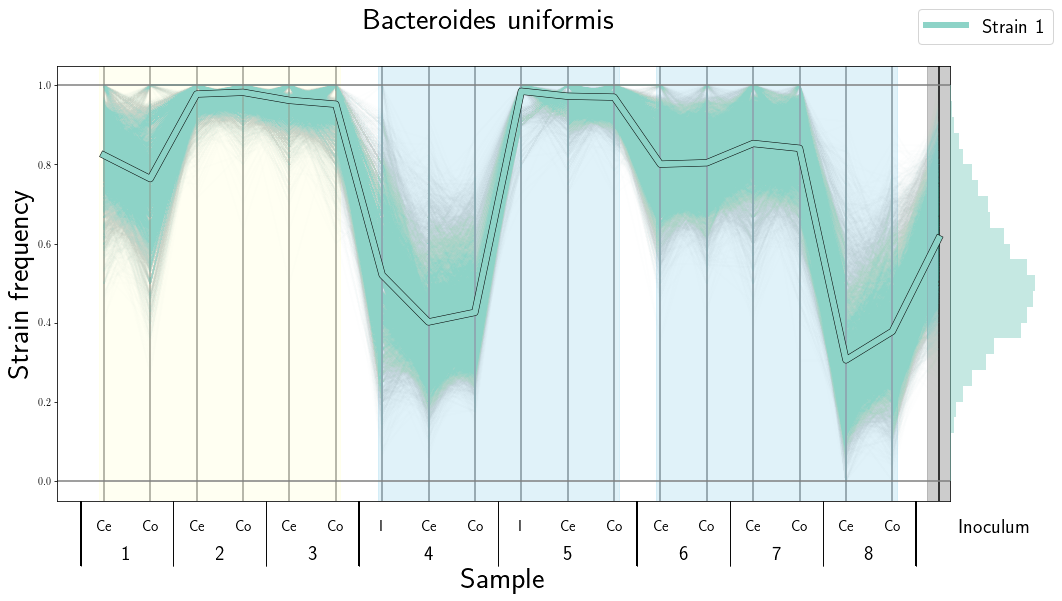

In [27]:
blank = False

key_to_sort = "mouse_number"
secondary_key = "region"


cmap_cage = []
colors_library = [(1, 1, 0.8, 0.25), #creamy yellow
                  (0.529, 0.808, 0.922, 0.25), #sky blue
                  (0.529, 0.808, 0.922, 0.25)]
                  #(0.529, 0.808, 0.722, 0.25), #green blue
                  #(0.294, 0.427, 0.804, 0.15)] #purple blue
if "Cage 1" in mcage_sample_dic:
#     cmap_cage.append(colors_library(0))
    cmap_cage.append(colors_library[0])
if "Cage 2" in mcage_sample_dic:
    cmap_cage.append(colors_library[1])
    
if "Cage 3" in mcage_sample_dic:
    cmap_cage.append(colors_library[2])
    

cmap_clus = get_cmap(5,name="Set3")

fig,ax = plt.subplots(figsize=(16,8))
fig.suptitle(fu.get_pretty_species_name(species),size=30)

for i,f in enumerate(final_f):
    if blank:
            ff = reorder_sort(f,key_to_sort).sort_index(key=lambda x: x.map(order_dict))
    else:
        ff = reorder_sort(f,key_to_sort).sort_index(key=lambda x: x.map(order_dict))
        ax.plot(ff.values,zorder=100,lw=6,color=cmap_clus(i),label=f"Strain {i+1}");
        ax.plot(ff.values,zorder=80,lw=7,color="k");
        if len(final_clusters) != 0:
            ff_c = reorder_sort(final_clusters[i].T,key_to_sort).T.sort_index(key=lambda x: x.map(order_dict),axis=1)
            ax.plot(ff_c.sample(min(ff_c.shape[0],10000)).T.values,color=cmap_clus(i),alpha=.01)
        else:
            for i in np.arange(len([Fs])):
                ff_c = reorder_sort((1-Fs).T,key_to_sort).T.sort_index(key=lambda x: x.map(order_dict),axis=1)
                ax.plot(ff_c.sample(min(ff_c.shape[0],10000)).T.values,color=cmap_clus(i),alpha=.01)



# ff = reorder_sort(final_f[1],key_to_sort).sort_index(key=lambda x: x.map(order_dict))
# ax.plot(ff.values,zorder=100,lw=6,color=cmap_clus(1),label=f"Strain {i+1}");
# ax.plot(ff.values,zorder=80,lw=7,color="k")
# ff_c = reorder_sort(final_clusters[1].T,key_to_sort).T.sort_index(key=lambda x: x.map(order_dict),axis=1)
# ax.plot(ff_c.sample(min(ff_c.shape[0],10000)).T.values,color=cmap_clus(1),alpha=.01)

major_x = []
minor_x = []
labels = []

second_xlabels = list(ff.index.get_level_values(secondary_key))


#Making the vertical lines and labels
i = 0
for key, item in all_sample_dics[key_to_sort].items():
    
    xmin = item.min() 
    xmax = item.max()
    
    for e in item:
        if key == "Inoculum":
            ax.axvline(e,color="k",zorder=0,alpha=1)
        else:
            ax.axvline(e,color="k",zorder=0,alpha=.5)   
            
        ax.text(e, -0.1, abbreviate_gut_site(second_xlabels[e], blank_inoc = True), ha='center',va='top', clip_on=False,size=15, rotation=0)
        
    if xmin != xmax:
        major_x.extend([xmin,(xmax + xmin)/2,xmax])
        minor_x.append((xmax + xmin)/2)
        labels.extend(["",key,""])
    else:
        major_x.append(xmin)
        minor_x.append(xmax)
        labels.extend([key])   
        
    i+=1
    
    if ("Inoculum" not in all_sample_dics[key_to_sort]) & (max(all_sample_dics[key_to_sort]) == key):
        ax.vlines(item[0] - 0.5, 0, -0.15, color='black', lw=0.8, clip_on=False, transform=ax.get_xaxis_transform())
        ax.vlines(item[-1] + 0.5, 0, -0.15, color='black', lw=2, clip_on=False, transform=ax.get_xaxis_transform())

    elif key == "Inoculum":
        ax.vlines(item[0] - 0.5, 0, -0.15, color='black', lw=0.8, clip_on=False, transform=ax.get_xaxis_transform())
    else:
        ax.vlines(item[0] - 0.5, 0, -0.15, color='black', lw=0.8, clip_on=False, transform=ax.get_xaxis_transform())
        ax.vlines(item[-1] + 0.5, 0, -0.15, color='black', lw=0.8, clip_on=False, transform=ax.get_xaxis_transform())

#Making the vertical colors
key_to_sort = "cage"
i = 0    
for key, item in sorted(all_sample_dics[key_to_sort].items()):
        
    xmin = item.min() 
    xmax = item.max()
        
    if (key == max(all_sample_dics[key_to_sort])):
        ax.vlines(item[0] - 0.5, 0, -0.15, color='black', lw=2, clip_on=False, transform=ax.get_xaxis_transform())
        if "Inoculum" != max(all_sample_dics[key_to_sort]):
            ax.vlines(item[-1] + 0.5, 0, -0.15, color='black', lw=2, clip_on=False, transform=ax.get_xaxis_transform())
            ax.axvspan(xmin - .25,xmax+.25,color=cmap_cage[i]) #,alpha=.2
        else:
            ax.axvspan(xmin - .25,xmax+.25,alpha=.2,color='black') 

        i+=1
    else:
        ax.axvspan(xmin - .1,xmax+.1,color=cmap_cage[i]) #alpha=.2,
        ax.vlines(item[0] - 0.5, 0, -0.15, color='black', lw=2, clip_on=False, transform=ax.get_xaxis_transform())
        ax.vlines(item[-1] + 0.5, 0, -0.15, color='black', lw=2, clip_on=False, transform=ax.get_xaxis_transform())

        i+=1


ax.set_xticks(major_x)
ax.set_xticks(minor_x, minor = True)
ax.set_xticklabels([label if label != "Inoculum" else "" for label in labels]);

ax.axhline(0,color="grey")
ax.axhline(1,color="grey")

ax.tick_params(axis = 'x', which = 'major', length=0,labelsize = 20,pad=45)
ax.tick_params(axis = 'x', which = 'minor', length = 10,labelsize = 0)
    
ax.set_ylabel("Strain frequency",size=30)
ax.set_ylim([-0.05,1.05]);
if "Inoculum" in labels:
    ax.set_xlim([-1,max(major_x)+0.25]);
    

ax.set_xlabel("Sample", size = 30)


fig.legend(prop={"size":20});
# fig.legend(prop={"size":20}, bbox_to_anchor=(0.85, 0.5));

        
############ ADDING SFS #################
# Create a new axis on the right side
if ("Inoculum" in labels):

    ax_hist = ax.inset_axes([1, 0, 0.1, 1])
    
    if len(final_clusters) ==0:
        hist_data = Fs["Inoculum"].dropna().values
        ax_hist.hist(hist_data, alpha = 0.5, bins = 25, color = cmap_clus(0), orientation = "horizontal")
    else:   
        for i,final_cluster in enumerate(final_clusters):
            hist_data = final_cluster["Inoculum"].dropna().values
            ax_hist.hist(hist_data, alpha = 0.5, bins = 25, color = cmap_clus(i), orientation = "horizontal")
    
#     final_cluster = final_clusters[1]
#     hist_data = final_cluster["Inoculum"].dropna().values
#     ax_hist.hist(hist_data, alpha = 0.5, bins = 25, color = cmap_clus(1), orientation = "horizontal")

#     hist_data = Fs["Inoculum"].dropna().values
#     ax_hist.hist(hist_data, alpha = 0.5, bins = 25, color = "grey", orientation = "horizontal")
    
    ax_hist.invert_yaxis()
    ax_hist.set_yticks([])
    ax_hist.set_xticks([])
    ax_hist.set_frame_on(False)
    ax_hist.invert_yaxis()

    # Set the title for the histogram
    ax_hist.set_xlabel("Inoculum", fontsize = 20, labelpad=17.5)

#plt.tight_layout()


In [28]:
if (len(final_f) > 0) & (len(Fs.columns) > 0):

    #Figure directory
    figure_directory = "%s%s%s" % (config.figure_directory, "strain_phasing/", species)
    if not os.path.exists(figure_directory):
        os.makedirs(figure_directory)
        print("Figure directory created successfully!")
    else:
        print("Figure directory already exists.")
    if blank:
        figure_path = "%s/%s_strain_phasing_blank.png" % (figure_directory, species)
    else:
        figure_path = "%s/%s_strain_phasing_mergedcluster.png" % (figure_directory, species)
    
#     figure_path = "%s/%s_strain_phasing_blank_nohist.png" % (figure_directory, species)
#     figure_path = "%s/%s_strain_phasing_1snvcluster.png" % (figure_directory, species)

    fig.savefig(figure_path, facecolor='white', transparent=False, dpi=300,bbox_inches='tight')






Figure directory already exists.


In [ ]:
blank